# INPUT DATA AND MODEL SETUP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# INPUT SECTION
# Grid definition
nz = 25
dz = 5
# Parameters definition (Van Genuchten)
wet = 0.495 # wet moisture content
dry = 0.24  # dry moisture content
avg = 0
thr = 0.124
ths = 0.495
alpha = 0.015
rksat = 1.23e-5
rm = 0.5
rn = 1 / (1 - rm)

# MODEL SETUP
def condf(th):
    if th >= ths:
        return rksat
    else:
        xx = (th - thr) / (ths - thr)
        return rksat * (xx**0.5) * (1 - (1 - xx**(1 / rm))**rm)**2

def headf(th):
    if th >= ths:
        return 0
    else:
        xx = (th - thr) / (ths - thr)
        return -(xx**(-1 / rm) - 1)**(1 / rn) / alpha

# Explicit finite difference scheme build up
def update(dry, dt, dtdz, dz, nz, wet, water):
    darcy = np.zeros(nz)

    h_old = headf(wet) # top boundary condition
    c_old = condf(wet) # top boundary condition

    for iz in range(1, nz + 1):
        h_new = headf(water[iz - 1])
        c_new = condf(water[iz - 1])

        # Arithmetic or geometric average for Conductivity
        if avg == 0:
            cond = 0.5 * (c_old + c_new)
        else:
            cond = np.sqrt(c_old * c_new)

        # darcy(iz) corresponds to x(iz-0.5)-(iz-0.5)*dz
        darcy[iz - 1] = -cond * ((h_new - h_old) / dz - 1)
        h_old = h_new
        c_old = c_new

    # Now update the theta values
    for iz in range(1, nz):
        dwater = -dtdz * (darcy[iz] - darcy[iz - 1])
        water[iz - 1] = water[iz - 1] + dwater
        water[nz - 1] = water[nz - 2] # bottom boundary condition

    return water

# SIMULATION RUN

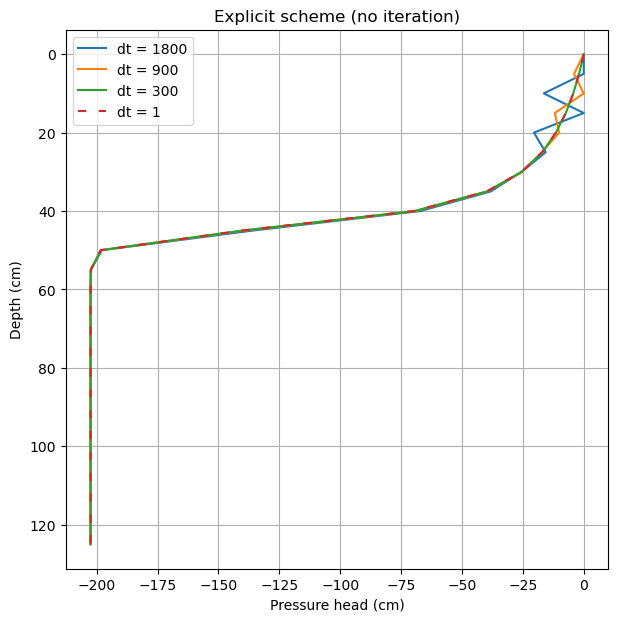

In [2]:
# List of dt values to run the simulation for
dt_values = [1800, 900, 300, 1]

# Lists to store results for plotting
z_values_list = []
water_values_list = []
head_values_list = []

for dt in dt_values:
    dtdz = dt / dz
    water = np.zeros(nz)  # Initialize water content array

    # Set water array values (Initial condition)
    for iz in range(1, nz+1):
        water[iz - 1] = dry

    # Run the simulation
    sim_time = 360000
    t = 0  # set time to 0 and it will run until the simulation time

    z_values = []
    water_values = []
    head_values = []

    while t < sim_time:
        t += dt

        run = update(dry, dt, dtdz, dz, nz, wet, water)

        # Append z, moisture, and head values for plotting (for the last time step)
        z_values = np.hstack([0, [iz * dz for iz in range(1, nz + 1)]])
        head_values = np.hstack([headf(wet), [headf(water[iz - 1]) for iz in range(1, nz + 1)]])
        water_values = np.hstack([wet, [water[iz - 1] for iz in range(1, nz + 1)]])

        # Break out of the loop if the next time step exceeds sim_time
        if t >= sim_time:
            break

    # Append results for this dt value to the lists
    z_values_list.append(z_values)
    water_values_list.append(water_values)
    head_values_list.append(head_values)

# Plotting pressure head for all dt values
plt.figure(figsize=(7, 7))

for i, dt in enumerate(dt_values):
    if dt == 1:
        # Plot with a dashed line for dt=1
        plt.plot(head_values_list[i], z_values_list[i], label=f'dt = {dt}', linestyle='--', dashes=(4, 6))
    else:
        # Plot with a solid line for other dt values
        plt.plot(head_values_list[i], z_values_list[i], label=f'dt = {dt}')

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.title('Explicit scheme (no iteration)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import pandas as pd

# Convert arrays to dataframes
z_df = pd.DataFrame({'Depth (cm)': z_values})
theta_df = pd.DataFrame({'Moisture content (-)': water_values})
psi_df = pd.DataFrame({'Pressure head (cm)': head_values})

# Concatenate dataframes along columns
simulation_df = pd.concat([z_df, theta_df, psi_df], axis=1)

# Display the dataframe
print(simulation_df)

    Depth (cm)  Moisture content (-)  Pressure head (cm)
0            0              0.495000            0.000000
1            5              0.494847           -1.918045
2           10              0.494226           -4.313174
3           15              0.492749           -7.378260
4           20              0.489662          -11.433153
5           25              0.483415          -17.062280
6           30              0.470532          -25.491088
7           35              0.442470          -39.838377
8           40              0.380495          -69.670179
9           45              0.282949         -140.601360
10          50              0.242197         -198.352111
11          55              0.240056         -202.418834
12          60              0.240001         -202.525461
13          65              0.240000         -202.528053
14          70              0.240000         -202.528114
15          75              0.240000         -202.528116
16          80              0.2